# News Classification using NB , MultinomialNB, SGD Classifier

In [27]:
import requests
import json
import time
import pandas as pd
import numpy as np
import re
import os
import wordcloud 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report,confusion_matrix
import random as rd

In [28]:
url = "https://content.guardianapis.com/search?section=%s&show-fields=body&page=%s&page-size=200&api-key="

In [29]:
key = "" #guardian api key
url = url + key
types=["technology","lifeandstyle","business","sport","culture","environment"]
filename = "news_database.csv"
totalpage = 10 #1Page contains 200 articles
#scrap(type_)

In [30]:
def get_articles(types_):
    if filename in os.listdir("."):
        df_ = pd.read_csv(filename)
        print("file found")
    else:
        print("creating article dataframe...")
        textdata =[]
        label = []
        for typ in types_:
            for k in range(1,totalpage+1): 
                u1 = url % (typ,str(k))
                data = requests.get(u1)
                parsed_data = json.loads(data.text)
                if (parsed_data["response"]["status"] == "ok"):
                    for art in parsed_data["response"]["results"]:
                        textdata.append(art["fields"]["body"])
                        label.append(typ)
                print(len(label))       
                time.sleep(2)
        df_ = pd.DataFrame({'Text': textdata,'Label': label,})
        df_.to_csv(filename, encoding='utf-8')
    return df_

In [31]:
df =  get_articles(types)

file found


In [32]:
df = df.replace("(<figure.*?</figure>)",' ', regex=True)
df = df.replace("(<a\sh.*?</a>)",' ', regex=True)
df = df.replace('<[^>]*>', ' ', regex=True)
df = df.replace('â€.', ' ', regex=True)
df = df.replace("[^a-zA-Z]"," ", regex=True)
for i in range(5):
    df = df.replace("\s(\w{1,3})\s",' ', regex=True)

In [33]:
df.Label = pd.Categorical(df.Label)
df['Category'] = df.Label.cat.codes
df.Label.value_counts()

technology      2000
sport           2000
lifeandstyle    2000
environment     2000
culture         2000
business        2000
Name: Label, dtype: int64

In [34]:
if 'filename.csv' not in os.listdir("."):
    df.to_csv("filename.csv", encoding='utf-8')
df.head()

,Unnamed: 0,Text,Label,Category
0,0,World Bank reassuring message those fearful b...,technology,5
1,1,Ryker Price Looking like Trans...,technology,5
2,2,When story told historians hard pressed...,technology,5
3,3,This March Facebook coming under global scru...,technology,5
4,4,Facebook accounts were affected data brea...,technology,5


In [35]:
#Split Test and Training
np.random.RandomState(42)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [13]:
#train=train.iloc[0:100]

In [36]:
train.head()

,Unnamed: 0,Text,Label,Category
0,9738,There world knows throw party like Elton John...,culture,1
1,8498,Avril Lavigne raised eyebrows recently when d...,culture,1
2,9890,Superman lives Wonder Woman charms Batmen f...,culture,1
3,3117,Plant this love clematis have room that spr...,lifeandstyle,3
4,2796,Fill grid using numbers Each nu...,lifeandstyle,3


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.Text)
X_train_counts.shape

(8400, 86511)

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(8400, 86511)

In [39]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train.Label)

In [40]:
from sklearn.pipeline import Pipeline

In [71]:
text_clf = Pipeline([('vect', CountVectorizer()), #convers strings to integer counts
...                      ('tfidf', TfidfTransformer()), #converts integer counts to weight TF-IDF scores
...                      ('clf', MultinomialNB()), #train on TF-IDF vectors with Naive Bayes Classifier
... ])
text_clf = text_clf.fit(train.Text, train.Label)

In [74]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
predicted = text_clf.predict(test.Text)
np.mean(predicted == test.Label)

0.8705555555555555

In [77]:
from sklearn import metrics
print(metrics.confusion_matrix(test['Label'], predicted))

[[512   4  20   2   1  14]
 [ 44 532   7  28   2  20]
 [ 51   5 519  31   1  10]
 [ 25  56  18 478  13  14]
 [  7   6   0   5 593   3]
 [ 46   9   7  16   1 500]]


Accuracy : %87.0556


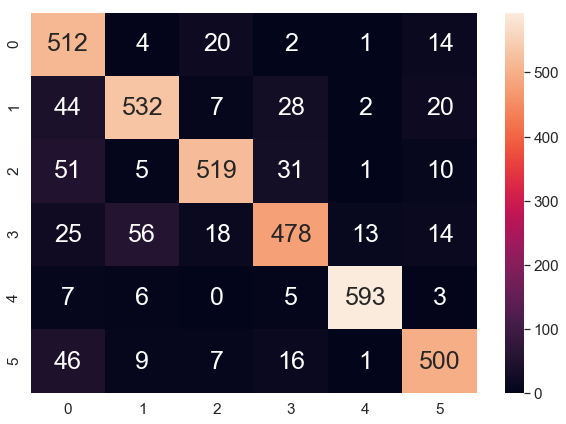

In [78]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(test['Label'], predicted)
df_cm = pd.DataFrame(array, range(6),range(6))
(df_cm)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 25}, fmt="d")# font size
print ("Accuracy : %{:.4f}".format(((array[0][0]+array[1][1]+array[2][2]+array[3][3]+array[4][4]+array[5][5])/len(test))*100))

In [102]:
print(classification_report(test['Label'], predicted))

              precision    recall  f1-score   support

    business       0.75      0.93      0.83       553
     culture       0.87      0.84      0.85       633
 environment       0.91      0.84      0.87       617
lifeandstyle       0.85      0.79      0.82       604
       sport       0.97      0.97      0.97       614
  technology       0.89      0.86      0.88       579

 avg / total       0.88      0.87      0.87      3600



In [79]:
from sklearn.linear_model import SGDClassifier

In [80]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
...                      ('tfidf', TfidfTransformer()),
...                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
...                                            alpha=1e-3, n_iter=5, random_state=42)),
... ])

In [81]:
_ = text_clf_svm.fit(train.Text, train.Label)

C:\Users\AKAYA\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [82]:
predicted_svm = text_clf_svm.predict(test.Text)

In [83]:
np.mean(predicted_svm == test.Label)

0.8919444444444444

Accuracy : %89.1944


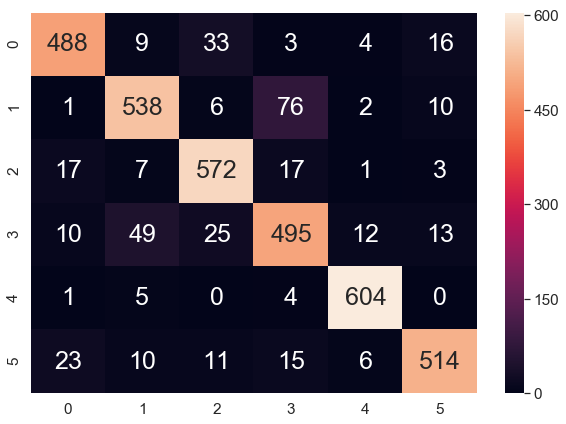

In [84]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(test['Label'], predicted_svm)
df_cm = pd.DataFrame(array, range(6),range(6))
(df_cm)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 25}, fmt="d")# font size
print ("Accuracy : %{:.4f}".format(((array[0][0]+array[1][1]+array[2][2]+array[3][3]+array[4][4]+array[5][5])/len(test))*100))

In [101]:
print(classification_report(test['Label'], predicted_svm))

              precision    recall  f1-score   support

    business       0.90      0.88      0.89       553
     culture       0.87      0.85      0.86       633
 environment       0.88      0.93      0.91       617
lifeandstyle       0.81      0.82      0.82       604
       sport       0.96      0.98      0.97       614
  technology       0.92      0.89      0.91       579

 avg / total       0.89      0.89      0.89      3600



In [64]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [65]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [66]:
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

In [67]:
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
...                      ('tfidf', TfidfTransformer()),
...                      ('mnb', MultinomialNB(fit_prior=False)),
... ])

In [69]:
text_mnb_stemmed = text_mnb_stemmed.fit(train.Text, train.Label)

In [70]:
predicted_mnb_stemmed = text_mnb_stemmed.predict(test.Text)
np.mean(predicted_mnb_stemmed == test.Label)

0.8661111111111112

Accuracy : %86.6111


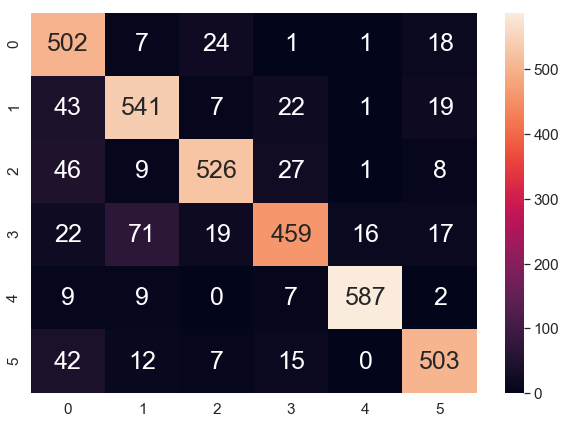

In [95]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(test['Label'], predicted_mnb_stemmed)
df_cm = pd.DataFrame(array, range(6),range(6))
(df_cm)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 25}, fmt="d")# font size
print ("Accuracy : %{:.4f}".format(((array[0][0]+array[1][1]+array[2][2]+array[3][3]+array[4][4]+array[5][5])/len(test))*100))

In [103]:
print(classification_report(test['Label'], predicted_mnb_stemmed))

              precision    recall  f1-score   support

    business       0.76      0.91      0.82       553
     culture       0.83      0.85      0.84       633
 environment       0.90      0.85      0.88       617
lifeandstyle       0.86      0.76      0.81       604
       sport       0.97      0.96      0.96       614
  technology       0.89      0.87      0.88       579

 avg / total       0.87      0.87      0.87      3600

